<h3 id="Reddit-AMA-sentiment-analysis-sample-IPython-notebook">Reddit AMA Sentiment Analysis Sample IPython Notebook<a href="#Reddit-AMA-sentiment-analysis-sample-IPython-notebook" class="anchor-link">¶</a></h3>
<p>This is a sample notebook that accompanies our tutorial on <a href="Link to WP tut">Sentiment Analysis of Reddit AMAs</a>. This solution uses:
<ul>
	<li>
<strong><a href="https://www.stage1.ng.bluemix.net/docs/services/AnalyticsforApacheSpark/index.html#using_spark_cloudant" target="_blank">Cloudant-spark Connector</a></strong>, which lets you connect your Analytics for Apache Spark service with Cloudant data.</li>
 <li><strong><a href="https://developer.ibm.com/clouddataservices/simple-data-pipe/" target="_blank">Simple-data-pipe</strong>, a Node.js app which provides an easy interface to move data from any source you want (create new connectors like one to Reddit) into Cloudant and dashDB where you can access it via IPython kernel.</li>
 <li><strong>Watson Tone Analyzer service</strong> to gauge comment sentiment through emotional and social tone measurement. </li></ul>
 </p>
<p>In this example, we load and analyze a recent IBM Reddit AMA. Run the following cells in order, or skip ahead to see these slick reporting results at the end:</p>
<p><a href="#Histogram">View histogram of comments by sentiments &gt; 70%</a></p>
<p><a href="#Comments">List comments by sentiments of top Reddit AMA posts</a></p>

In [1]:
from pyspark import SparkContext, SparkConf

Connect to an existing SparkContext.

In [2]:
sqlContext = SQLContext(sc)

Connect to the Cloudant database service you created in IBM Bluemix. Replace XXXX's with your Cloudant service credentials. The format of the connecting api is:

sqlContext.read.format("com.cloudant.spark").option("cloudant.host","XXXX-bluemix.cloudant.com").option("cloudant.username", "XXXX-bluemix").option("cloudant.password","XXXX").option("schemaSampleSize", "-1").load("sample database name")

In [3]:
df = sqlContext.read.format("com.cloudant.spark").option("cloudant.host","XXXX.cloudant.com").option("cloudant.username", "XXXX").option("cloudant.password","XXXX").option("schemaSampleSize", "-1").load("reddit_ibmama_top_comments_only")

Print database scheme off the Cloudant DataFrame returned by the cloudant-spark connector as starting point into analytics.

In [4]:
df.printSchema()

root
 |-- Agreeableness: string (nullable = true)
 |-- Analytical: string (nullable = true)
 |-- Anger: string (nullable = true)
 |-- Confident: string (nullable = true)
 |-- Conscientiousness: string (nullable = true)
 |-- Disgust: string (nullable = true)
 |-- Emotional_Range: string (nullable = true)
 |-- Extraversion: string (nullable = true)
 |-- Fear: string (nullable = true)
 |-- Joy: string (nullable = true)
 |-- Openness: string (nullable = true)
 |-- Sadness: string (nullable = true)
 |-- Tentative: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- _rev: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- id: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- pt_type: string (nullable = true)
 |-- text: string (nullable = true)
 |-- title: string (nullable = true)



Display top 20 rows of DataFrame in a tabular format.

In [5]:
df.show()

+-------------+----------+-----+---------+-----------------+-------+---------------+------------+-----+-----+--------+-------+---------+--------------------+--------------------+--------------+----------+----------+-------+------------+-----------------+--------------------+--------------------+
|Agreeableness|Analytical|Anger|Confident|Conscientiousness|Disgust|Emotional_Range|Extraversion| Fear|  Joy|Openness|Sadness|Tentative|                 _id|                _rev|        author|   created|    edited|     id|num_comments|          pt_type|                text|               title|
+-------------+----------+-----+---------+-----------------+-------+---------------+------------+-----+-----+--------+-------+---------+--------------------+--------------------+--------------+----------+----------+-------+------------+-----------------+--------------------+--------------------+
|        18.50|      0.00| 4.33|     0.00|            29.10|  22.69|          86.50|        4.10|22.09|22.36|

Register a temporary table with a unique name for performing SQL operations on the Cloudant DataFrame.

In [6]:
df.registerTempTable("reddit");

#### Compute distribution of sentiments as computed by the Watson Tone Analyzer

Compute distribution of sentiments to populate a Histogram chart showing number of comments by sentiment with values greater than 70%. Higher value of sentiment reflects higher emotional intensity.

In [7]:
sentimentDistribution=[0] * 13
#for i, sentiment in enumerate(df.columns[-23:13]): print sentiment

for i, sentiment in enumerate(df.columns[-23:13]):
    sentimentDistribution[i]=sqlContext.sql("SELECT count(*) as sentCount FROM reddit where cast(" + sentiment + " as String) > 70.0")\
        .collect()[0].sentCount

In [8]:
print sentimentDistribution

[10, 9, 0, 4, 5, 0, 15, 15, 0, 0, 5, 0, 12]


#Histogram

Barplot displaying histogram of comments by sentiments > 70%.

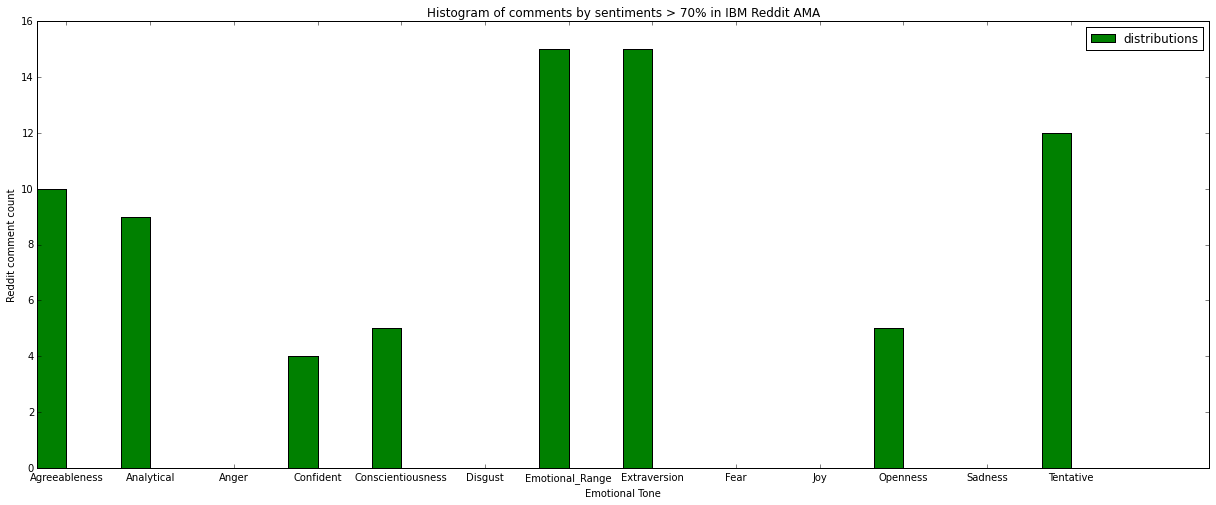

In [9]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
 
ind=np.arange(13)
width = 0.35
bar = plt.bar(ind, sentimentDistribution, width, color='g', label = "distributions")
 
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3.5, plSize[1]*2) )
plt.ylabel('Reddit comment count')
plt.xlabel('Emotional Tone')
plt.title('Histogram of comments by sentiments > 70% in IBM Reddit AMA')
plt.xticks(ind+width, df.columns[-23:13])
plt.legend()
 
plt.show()

#Comments
By Sentiment

Collect and list comments by sentiment to see where specific examples fall. Reading these results lets you reflect upon how participants feel and react. Some comments appear in multiple sentiment groups. Click on the sentiment to read comments.

In [11]:
comments=[]
htmlbody = ""

for i, sentiment in enumerate(df.columns[-23:13]):
    commentset = df.filter("cast(" + sentiment + " as String) > 70.0")
    comments.append(commentset.map(lambda p: p.author + "\n\n<p>" + p.text).collect())
    htmlbody = htmlbody + "<div class=\"container\">\n<div class=\"panel-group\">\n<div class=\"panel panel-default\">\n"
    htmlbody = htmlbody + "<div class=\"panel-heading\">" + "\n" + "<h4 class=\"panel-title\">" + "\n" + "<a data-toggle=\"collapse\" href=\"#" + sentiment + "\">" + sentiment + "</a>\n</h4>\n</div>"
    htmlbody = htmlbody + "<div id=" + sentiment + " class=\"panel-collapse collapse in\">" + "\n"
    for comment in comments[i]:
         htmlbody = htmlbody + "<div class=\"panel-body\">" + "[-]  " + comment + "\n</div>"
    htmlbody = htmlbody + "\n</div>\n</div>\n</div>\n</div>\n"    
#print htmlbody

get_ipython().run_cell_magic(u'HTML', u'',u'<head>'
u'<meta name="viewport" content="width=device-width, initial-scale=1">'
u'<link rel="stylesheet" href="http://maxcdn.bootstrapcdn.com/bootstrap/3.3.6/css/bootstrap.min.css">'
u'<script src="https://ajax.googleapis.com/ajax/libs/jquery/1.12.0/jquery.min.js"></script>'
  u'<script src="http://maxcdn.bootstrapcdn.com/bootstrap/3.3.6/js/bootstrap.min.js"></script>'
u'</head>'
u'<body>'
u''
    + htmlbody +
u''
u'</body>')